In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = "data/train.p"
validation_file = "data/valid.p"
testing_file    = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test =X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))  #https://stackoverflow.com/a/12282286

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import pandas as pd
import numpy as np
import textwrap
from PIL     import Image
from os      import listdir
from os.path import isfile, join, basename

In [73]:
random.seed()

class Logger:
    
    def __init__(self, name, owner=None):
        if owner is not None:
            # https://stackoverflow.com/a/7983848
            name = name + "-" + str(id(owner))[-4:]
        
        self.name = name
        return
        
    def log(self, msg):
        print (self.name + " | " + msg)
        return


class SignNames_CSV:

    def __init__(self):
        self.df = pd.read_csv("signnames.csv")
        return
    
    def signName(self, class_id):
        return self.df.at[class_id, 'SignName']
    
signnames_csv = SignNames_CSV()


def signName(class_id):
    return signnames_csv.signName(class_id)


class TrafficSignsDataset:
    
    def __init__(self, *args):
        
        self.logger = Logger("TrafficSignsDataset", self)
        
        if len(args) == 3:
            images, labels, n_classes = args
        else:
            #-- len args == 2
            folder_name, n_classes = args
            images, labels = self.loadFolder(folder_name)
            
        self.org_X = images
        self.org_y = labels
            
        self.X = self.org_X.copy()
        self.y = self.org_y.copy()
        
        self.n_classes = n_classes
        
        return

    def loadFolder(self, folder_nmame):
    
        msg = "Loading signs from {}..."
        self.logger.log(msg.format(folder_name))

        pathnames = [join(folder_name, f) 
                     for f in listdir(folder_name) if isfile(join(folder_name, f))]

        n = 0
        images = []
        labels = []

        for pathname in pathnames:
            
            filename = basename(pathname) 
            classId = filename.split(",")[0]

            pil_img = Image.open(pathname).convert('RGB')
            pil_img32x32 = pil_img.resize((32, 32), Image.BILINEAR)
            img = np.array(pil_img32x32)

            labels.append(classId)
            images.append(img)

            msg = "Loaded {} with label {}."
            self.logger.log(msg.format(filename, classId))

            n += 1

        msg = "...{} signs loaded."
        self.logger.log (msg.format(n))
        
        return images, labels
    
    def data(self):
        return (self.X, self.y)
    
    def processImages(self, img_processors):
        
        self.logger.log("Processing images...")
        
        for img_processor in img_processors:
            
            msg = "Applying {}() to images."
            self.logger.log(msg.format(img_processor.__name__))
            
            self.X = [img_processor(img) for img in self.X]
            
        self.logger.log("...images processed.")            
        
        return
    
    def addFakes (self, img_processors):
        
        self.logger.log("Adding fake images...")
        max_samples = np.max(np.bincount(self.y))
        
        for classId in range(self.n_classes):

            x = self.X[self.y == classId]
            y = self.y[self.y == classId]

            n_x = x.shape[0]

            aug_x = np.array([])
            aug_y = np.array([])

            if n_x < max_samples:

                n_repeats = (max_samples - n_x) // n_x
                n_remain = (max_samples - n_x) % n_x

                aug_x = np.repeat(x, n_repeats, axis=0)
                aug_x = np.concatenate ((aug_x, x[:n_remain]))
                for img_processor in img_processors:
                    aug_x = np.array([img_processor(img) for img in aug_x])

                aug_y = np.repeat(y, n_repeats, axis=0)
                aug_y = np.concatenate ((aug_y, y[:n_remain]))
                
                samples_added = max_samples - n_x
                msg = "Added {} fake images for sign classId {}."
                self.logger.log(msg.format(samples_added, classId))
                
            if aug_x.shape[0] > 0:
                self.X = np.concatenate((self.X, aug_x))
                self.y = np.concatenate((self.y, aug_y))
                
        self.X = np.array(self.X, dtype=np.uint8)
        self.logger.log ("...fake images added.")

        return
    
    def restoreOrgImages(self):
        
        self.X = np.array(self.org_X, dtype=np.uint8)
        self.y = np.array(self.org_y)
        
        self.logger.log("Original images and labels restored.")
        
        return
    
class Viewer:
    
    def __init__(self):
        return
    
    def imShowTrainingSigns(self, trainingSigns):
        
        ds = list(zip(trainingSigns.y, trainingSigns.X))
        df = pd.DataFrame(data=ds, columns=['Label', 'Image'])

        for classId in range(trainingSigns.n_classes):
            # https://pandas.pydata.org/pandas-docs/version/0.15/cookbook.html#building-criteria
            df_sel = df.loc[(df['Label'] == classId), 'Image'].sample(3)
            fig = plt.figure(figsize=(11, 3))
            fig.suptitle(signName(classId))
            for i in range(3):
                ax = plt.subplot(1, 3, i + 1)
                ax.imshow(df_sel.iloc[i])
            plt.show()    
        
        return
    
    def imShowTrainingSigns5x5(self, trainingSigns):
        fig = plt.figure(figsize=(11,11))
        num_rows = 5
        num_cols = 5
        for i in range(num_cols*num_rows):
            img = random.choice(trainingSigns.X)
            ax = plt.subplot(num_rows, num_cols, i + 1)
            ax.imshow(img)
        plt.show()
        return

    def barhPctBySigns(self, trainingSigns, validSigns, testSigns):
        y_train = trainingSigns.y
        y_valid = validSigns.y
        y_test  = testSigns.y
        
        bincount_y_train = np.bincount(y_train)
        bincount_y_valid = np.bincount(y_valid)
        bincount_y_test  = np.bincount(y_test)
        # bin_count[i] = num samples for sign i (where i=classId)

        pct_y_train = bincount_y_train / sum(bincount_y_train)
        pct_y_valid = bincount_y_valid / sum(bincount_y_valid)
        pct_y_test  = bincount_y_test  / sum(bincount_y_test)
        # pct_y_train[i] = percentage of total samples of sign i 

        pct_y_train_sorted_idx = np.argsort(pct_y_train)
        # pct_y_train_sorted_idx an array of sign classIds sorted by their percentage

        # ref: https://stackoverflow.com/a/59421062
        bar_wid = 0.3

        y_pos      = np.arange(len(pct_y_train))
        pcts       = [pct_y_train[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_valid = [pct_y_valid[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_test  = [pct_y_test[class_id] for class_id in pct_y_train_sorted_idx]
        y_labels   = [textwrap.fill(signName(class_id), width=25) 
                      for class_id in pct_y_train_sorted_idx]

        fig, ax = plt.subplots(figsize=(11, 35))

        ax.barh(y_pos + 2*bar_wid, pcts,       bar_wid, label="Training")
        ax.barh(y_pos + bar_wid,   pcts_valid, bar_wid, label="Valid")
        ax.barh(y_pos,             pcts_test,  bar_wid, label="Test")

        ax.set_yticks(y_pos  + bar_wid)
        ax.set_yticklabels(y_labels)
        ax.set_xlabel('Percentage of Sample')
        ax.set_title("Percentage of Sample by Sign and Dataset")

        plt.legend(loc='best')
        plt.margins(y=0)
        plt.show()

        return
    
    def barhCountTrainingSigns(self, trainingSigns):
        sign_count_y_train = np.bincount(trainingSigns.y)
        # sign_count[i] = num samples for sign i (where i=classId)

        # ref: https://stackoverflow.com/a/59421062
        y_pos        = np.arange(len(sign_count_y_train))
        counts_train = [sign_count_y_train[class_id] 
                        for class_id in range(trainingSigns.n_classes)]
        
        y_labels     = [textwrap.fill(signName(class_id), width=25) 
                        for class_id in range(trainingSigns.n_classes)]

        fig, ax = plt.subplots(figsize=(11, 35))

        # ax.barh(y_pos, counts_train)
        ax.barh(y_pos, counts_train)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(y_labels)
        ax.invert_yaxis()
        ax.set_xlabel('Number of Training Samples')
        ax.set_title("Number of Training Samples by Sign")

        plt.margins(y=0)
        plt.show()

        return        
    
    def imShowPredictions(self, images, predictions):
        
        num_images = len(images)
        
        fig, axs = plt.subplots(num_images, 2, figsize=(15, 3.5*num_images))
        if num_images == 1:
            axs = [axs]
        
        for ax, img, vals, idxs in zip(axs, images, predictions.values, predictions.indices):
            
            pcts  = [100*v for v in vals]
            signs = [textwrap.fill(signName(i), width=25) for i in idxs]
            
            # https://matplotlib.org/gallery/lines_bars_and_markers/barh.html#sphx-glr-gallery-lines-bars-and-markers-barh-py
            img_ax = ax[0]
            bar_ax = ax[1]

            img_ax.imshow(img)
            img_ax.set_title("Image of Sign")
            
            ypos = np.arange(len(signs))
            bar_ax.barh(ypos, pcts)
            bar_ax.set_yticks(ypos)
            bar_ax.set_yticklabels(signs)
            bar_ax.invert_yaxis()
            bar_ax.set_xlabel("Confidence")
            bar_ax.set_title("Classification (Top 5)")
            bar_ax.set_xlim([0,100])

        fig.suptitle("Model Classification of some German Traffic Signs", y = 1.0)
        fig.tight_layout()
        plt.show()    
        
        return
        

trainingSigns = TrafficSignsDataset(X_train, y_train, n_classes)
validSigns    = TrafficSignsDataset(X_valid, y_valid, n_classes)
testSigns     = TrafficSignsDataset(X_test, y_test, n_classes)
vwr           = Viewer()


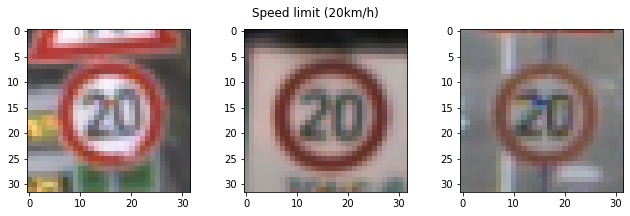

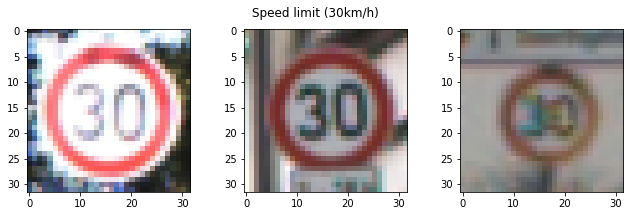

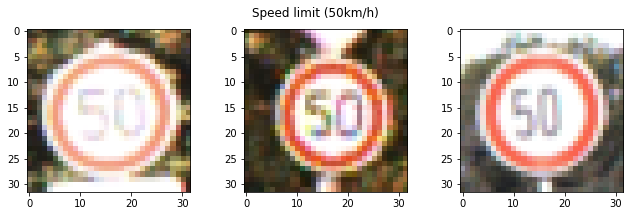

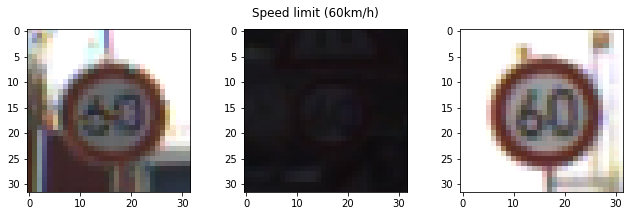

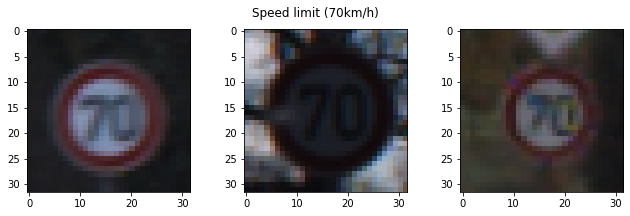

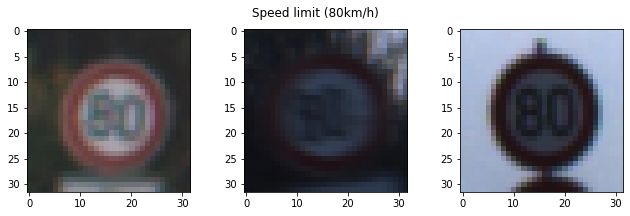

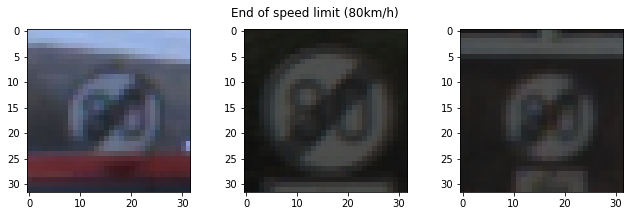

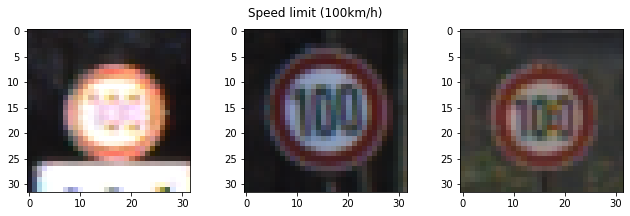

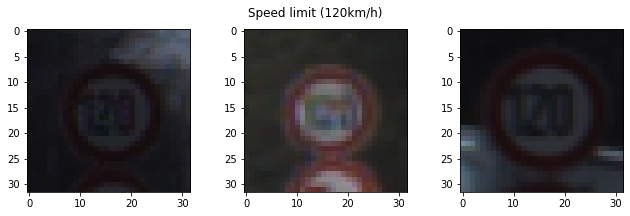

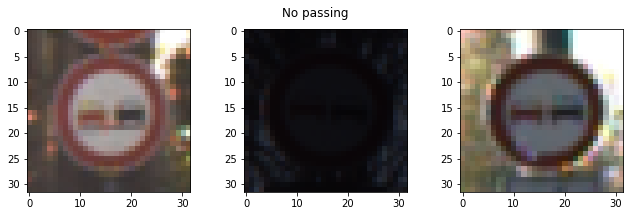

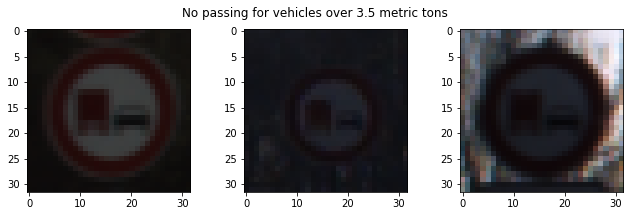

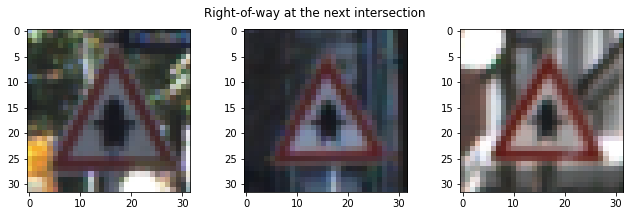

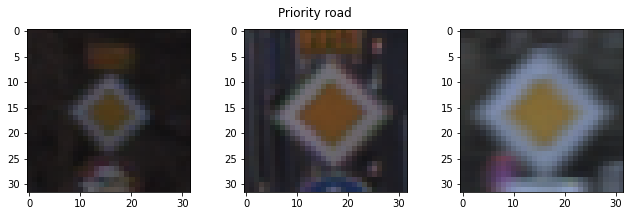

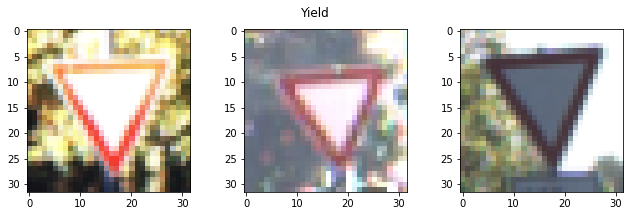

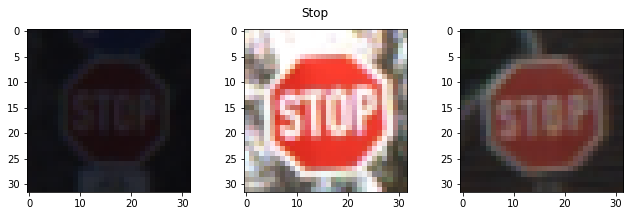

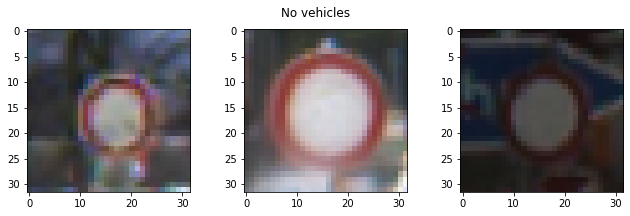

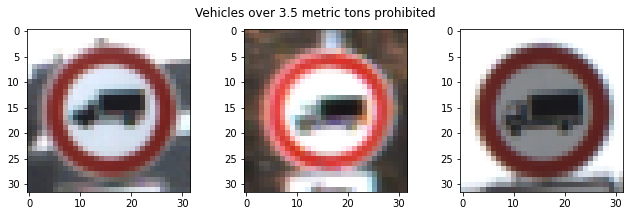

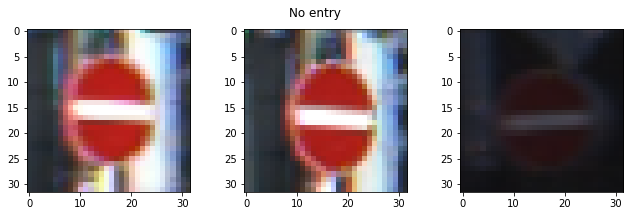

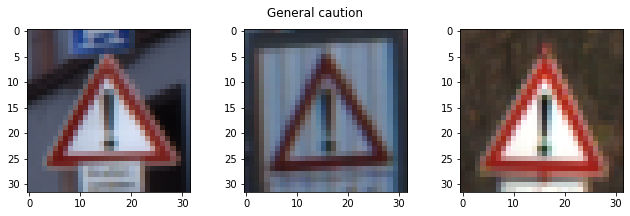

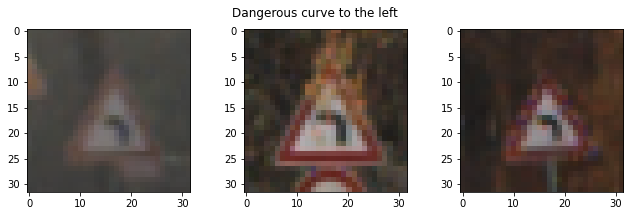

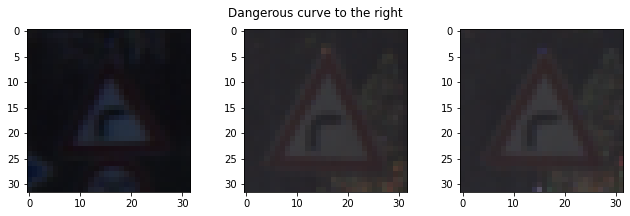

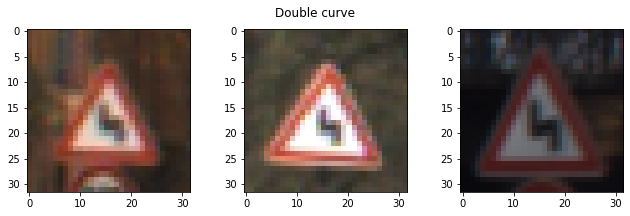

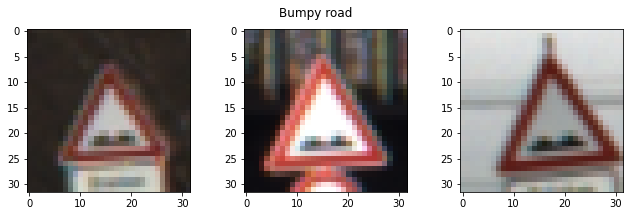

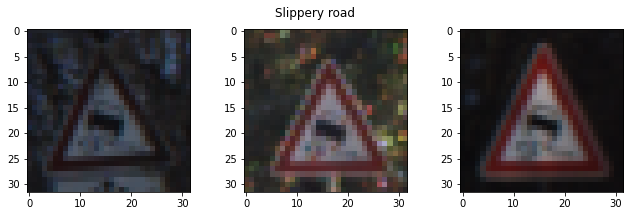

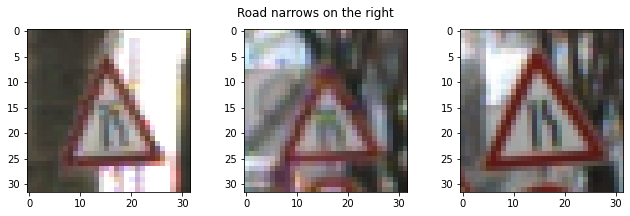

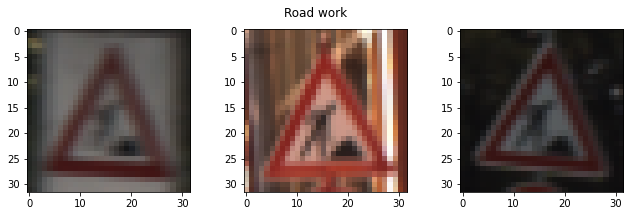

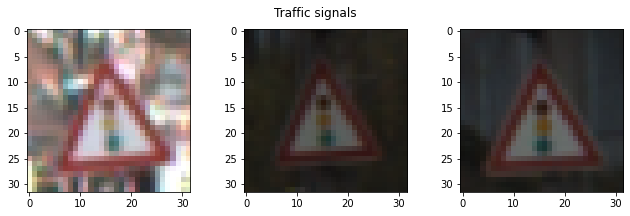

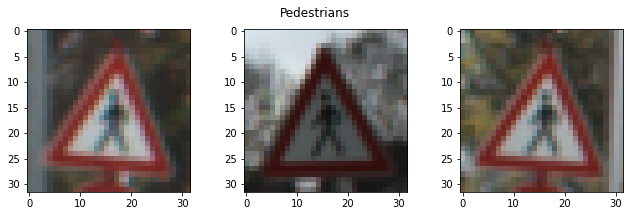

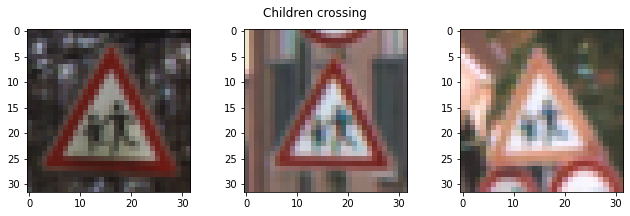

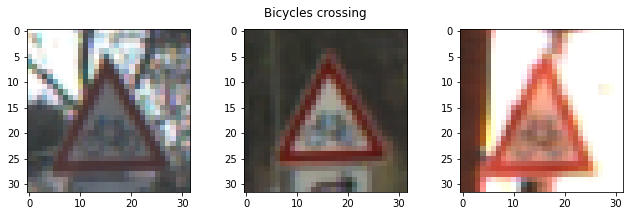

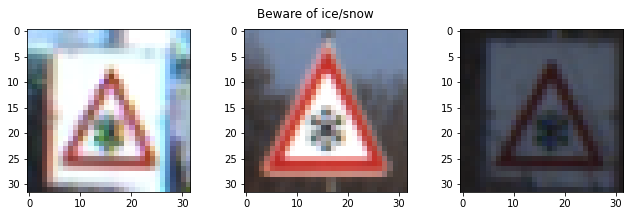

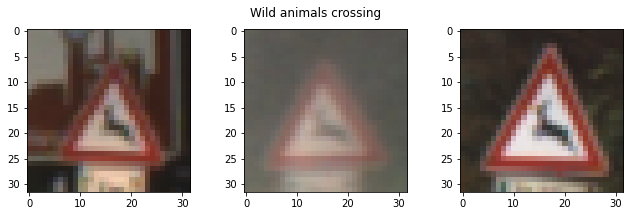

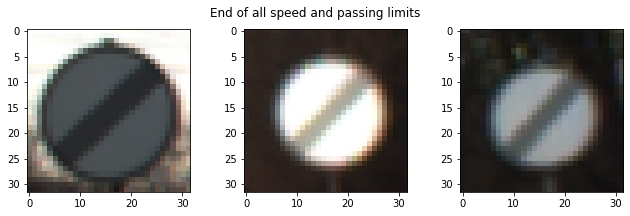

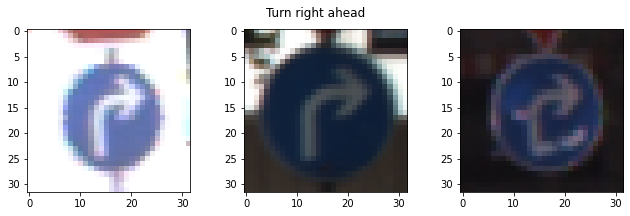

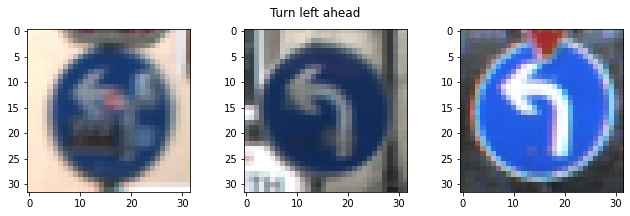

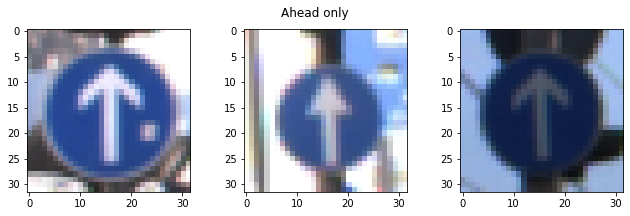

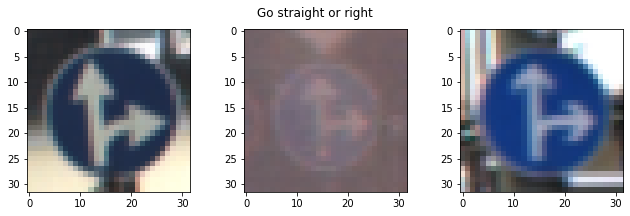

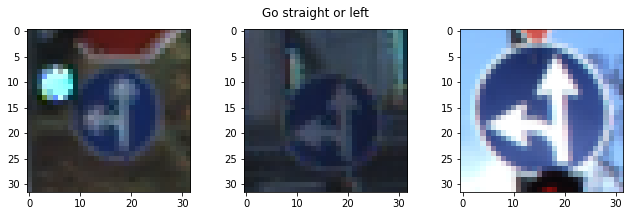

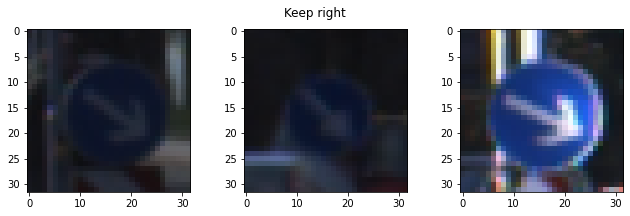

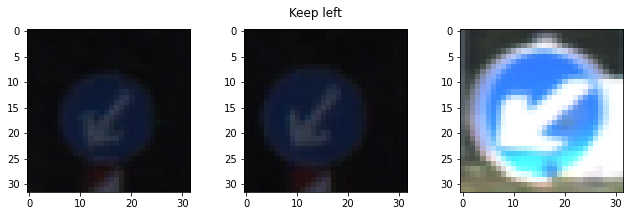

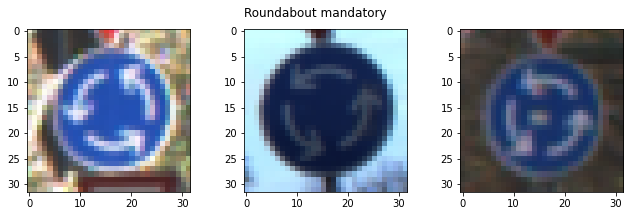

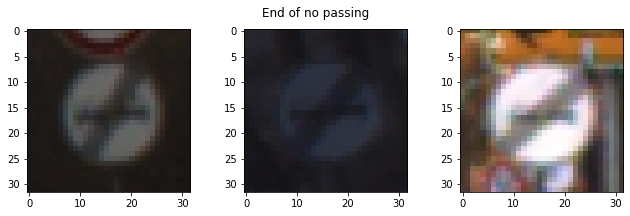

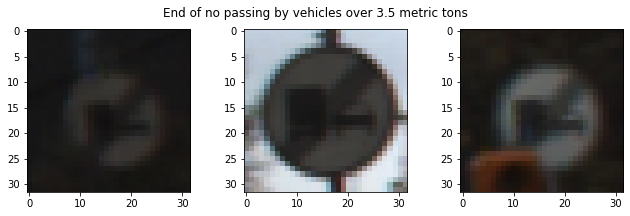

In [52]:
vwr.imShowTrainingSigns(trainingSigns)

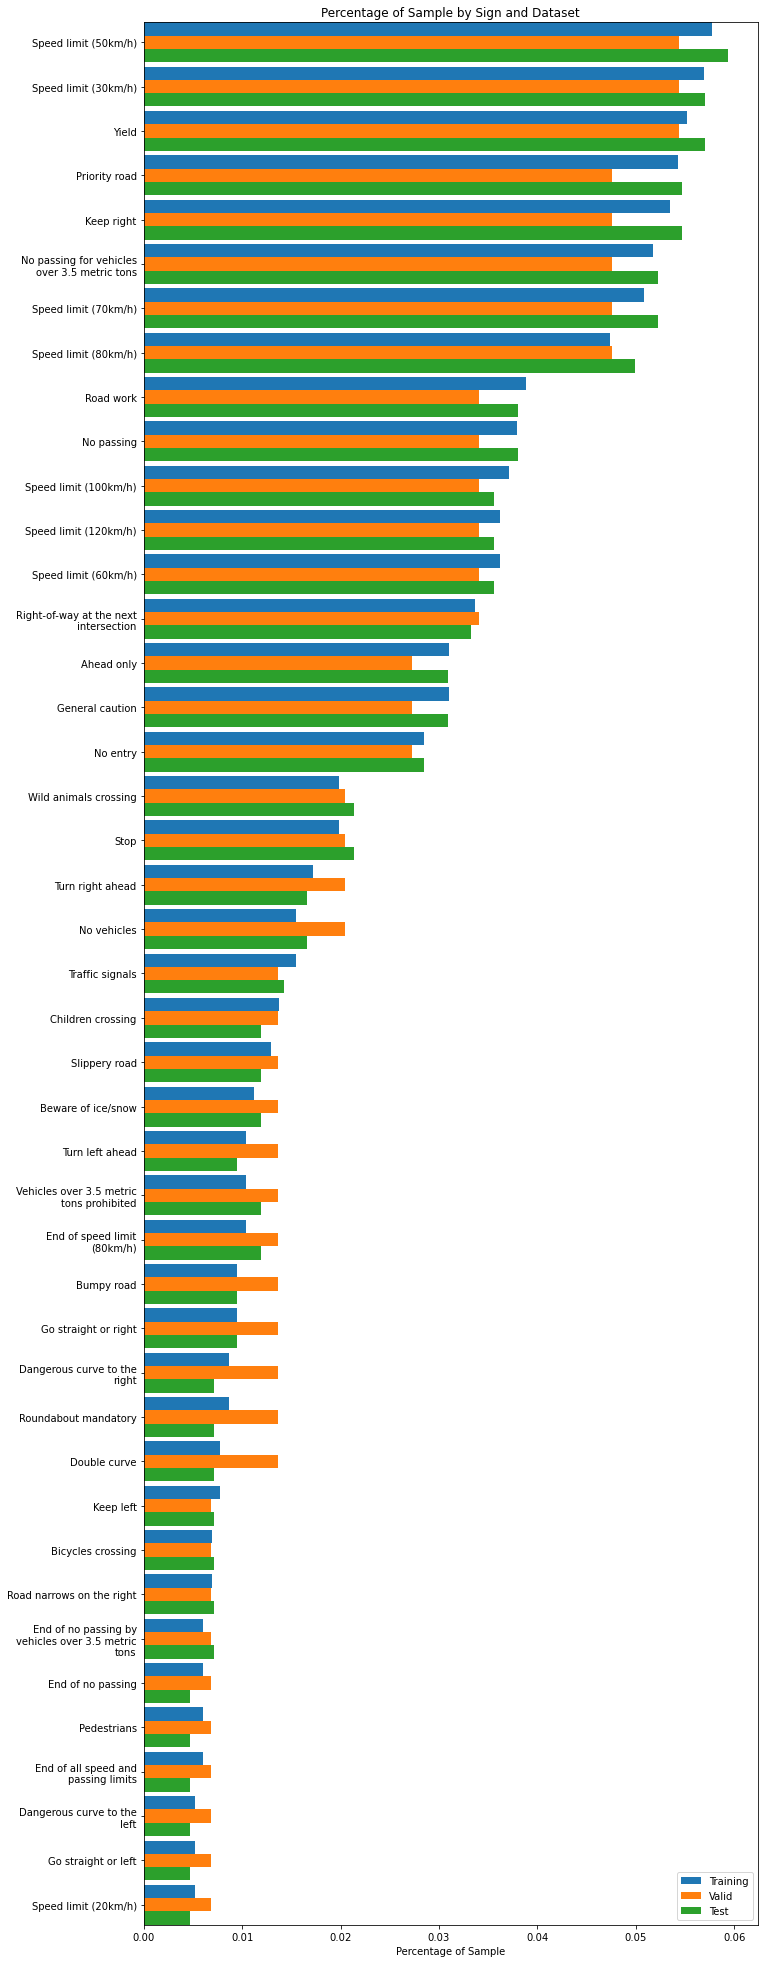

In [6]:
vwr.barhPctBySigns(trainingSigns, validSigns, testSigns)

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import numpy as np
import cv2
import skimage as sk
from skimage.transform import rotate

In [8]:
def RGB_to_norm(img):
    return (np.float32(img) - 128)/128

def norm_to_RGB(norm_img):
    return (np.uint8(128 * norm_img) + 128)

def equalizeHist(orgimg, v_thresh=128): #84
    hsv = cv2.cvtColor(orgimg, cv2.COLOR_RGB2HSV)
    mean_v = np.mean(hsv[:,:,2])
    if mean_v < v_thresh:
        equ = cv2.equalizeHist(hsv[:,:,2])
        hsv[:,:,2] = equ
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        img = orgimg
    return img

image_processors = [equalizeHist, RGB_to_norm]

# https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

def noise(image):
    return (sk.util.random_noise(image) * 255).astype(np.uint8)

def rotate (image):
    deg = random.uniform(-25, 25)
    return sk.transform.rotate(image, deg, preserve_range=True).astype(np.uint8)

def preserve(image):
    return image.astype(np.uint8)

def fakeify(image):
    #--- set noise to 0 because we losed too much image data
    f = random.choices ([preserve, rotate, noise], weights=[3, 1, 0])[0]
    return f(image)


In [32]:
trainingSigns.restoreOrgImages()
trainingSigns.addFakes([fakeify])

TrafficSignsDataset-0112 | Original images and labels restored.
TrafficSignsDataset-0112 | Adding fake images...
TrafficSignsDataset-0112 | Added 1830 fake images for sign classId 0.
TrafficSignsDataset-0112 | Added 30 fake images for sign classId 1.
TrafficSignsDataset-0112 | Added 750 fake images for sign classId 3.
TrafficSignsDataset-0112 | Added 240 fake images for sign classId 4.
TrafficSignsDataset-0112 | Added 360 fake images for sign classId 5.
TrafficSignsDataset-0112 | Added 1650 fake images for sign classId 6.
TrafficSignsDataset-0112 | Added 720 fake images for sign classId 7.
TrafficSignsDataset-0112 | Added 750 fake images for sign classId 8.
TrafficSignsDataset-0112 | Added 690 fake images for sign classId 9.
TrafficSignsDataset-0112 | Added 210 fake images for sign classId 10.
TrafficSignsDataset-0112 | Added 840 fake images for sign classId 11.
TrafficSignsDataset-0112 | Added 120 fake images for sign classId 12.
TrafficSignsDataset-0112 | Added 90 fake images for sig

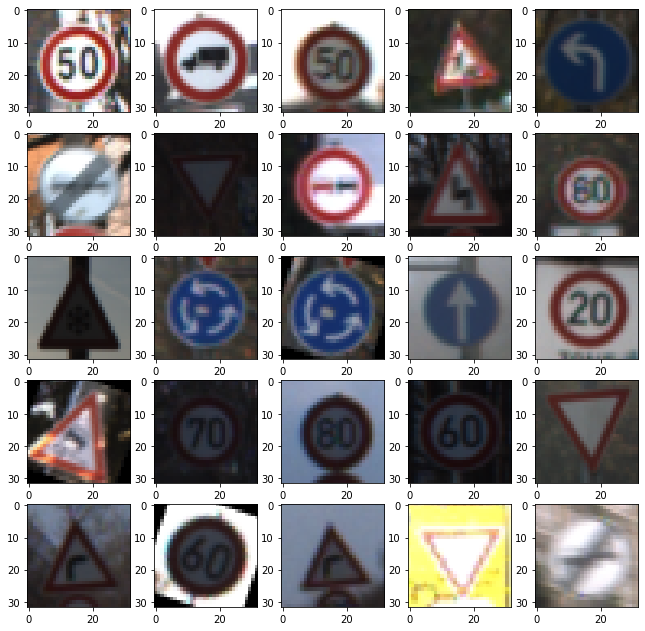

In [33]:
vwr.imShowTrainingSigns5x5(trainingSigns)

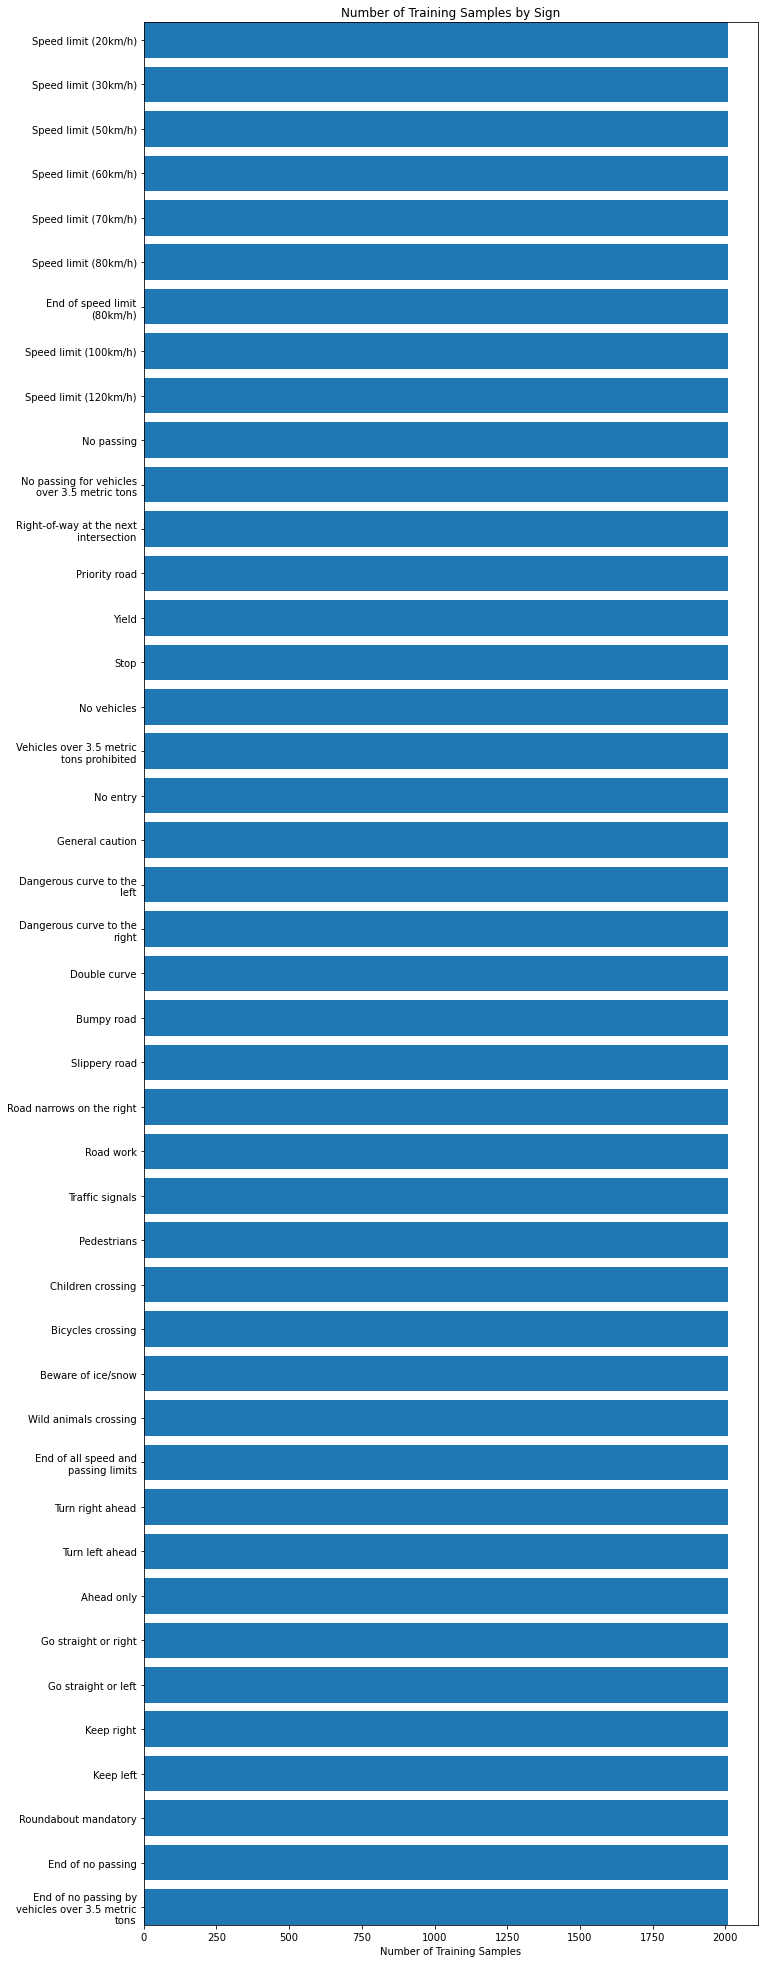

In [34]:
vwr.barhCountTrainingSigns(trainingSigns)

In [35]:
trainingSigns.processImages(image_processors)

validSigns.restoreOrgImages()
validSigns.processImages(image_processors)

testSigns.restoreOrgImages()
testSigns.processImages(image_processors)

TrafficSignsDataset-0112 | Processing images...
TrafficSignsDataset-0112 | ...images processed.
TrafficSignsDataset-0840 | Original images and labels restored.
TrafficSignsDataset-0840 | Processing images...
TrafficSignsDataset-0840 | ...images processed.
TrafficSignsDataset-6600 | Original images and labels restored.
TrafficSignsDataset-6600 | Processing images...
TrafficSignsDataset-6600 | ...images processed.


In [36]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from PIL import Image

In [37]:
def conv2D(x, output_shape, s=1, mu=0, sigma=0.1, activation=tf.nn.relu):
    
    input_shape = x.shape.as_list()[1:]
    
    input_depth  = input_shape[2]
    output_depth = output_shape[2]
    
    stride = [1, s, s, 1]
    
    # size of filter (length=Width)
    # ref: lesson 12: Solution: Convolution Output Shape for "VALID" padding
    f_ht  = input_shape[0] - output_shape[0]*s + 1
    f_wid = input_shape[1] - output_shape[1]*s + 1
    
    # shape of weights
    w_shape = (f_ht, f_wid, input_depth, output_depth)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_depth))
    c = tf.nn.conv2d(x, w, stride, padding='VALID') + b
    a = activation(c)
    
    return a


def pooling(x, output_shape, s=2, pool=tf.nn.max_pool):
    
    input_shape = x.shape.as_list()[1:]
    input_depth = input_shape[2]
    output_depth = output_shape[2]
    
    # size of filter
    # ref: lesson 23: Quiz: Pooling Mechanics
    f_ht  = input_shape[0] - (output_shape[0] - 1) * s
    f_wid = input_shape[1] - (output_shape[1] - 1) * s
    
    fil    = [1, f_ht, f_wid, 1]
    stride = [1, s, s, 1]
    
    p = pool(x, fil, stride, padding='VALID')
    
    return p


def connected(x, output_shape,  mu=0, sigma=0.1, activation=tf.nn.relu):
    input_shape = x.shape.as_list()[1]
    output_shape = output_shape[0]
    w_shape = (input_shape, output_shape)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_shape))
    z = tf.add(tf.matmul(x, w), b)
    
    if activation is None:
        a = z
    else:
        a = activation(z)
    
    return a


In [38]:
class Layer():
    def __init__(self, output_shape=None, probe=False):
        self.output_shape = output_shape
        self.probe = probe
        self.layer = None
        self.setName()
        return
    
    def setName(self):
        self.name = "Layer"
        return
    
    def afterAdd(self, model):
        return
    
    def summary(self):
        return self.name.ljust(10) + ":" + str(self.layer.shape)
    

class Input(Layer):

    def setName(self):
        self.name = "Input"
        return
    
    def connect(self, prev_layer):
        self.layer = prev_layer
        return self.layer
    

class Conv2D(Layer):

    def setName(self):
        self.name = "Conv2D"
        return
    
    def connect(self, prev_layer):
        self.layer = conv2D(prev_layer, self.output_shape)
        return self.layer
    

class Pooling(Layer):
    
    def setName(self):
        self.name = "Pooling"
        return

    def connect(self, prev_layer):
        self.layer = pooling(prev_layer, self.output_shape)
        return self.layer
    
    
class Dropout(Layer):
    
    def setName(self):
        self.name = "Dropout"
        return

    def connect(self, prev_layer):
        self.layer = tf.nn.dropout(prev_layer, self.keep_prob)
        return self.layer
    
    def afterAdd(self, model):
        self.keep_prob = model.keep_prob
        return
    

class Flatten(Layer):
    
    def setName(self):
        self.name = "Flatten"
        return

    def connect(self, prev_layer):
        self.layer = flatten(prev_layer)
        return self.layer
    
    
class Connected(Layer):

    def setName(self):
        self.name = "Connected"
        return
    
    def connect(self, prev_output):
        self.layer = connected(prev_output, self.output_shape)
        return self.layer
    
    
class Output(Layer):
    
    def setName(self):
        self.name = "Output"
        return

    def afterAdd(self, model):
        self.n_classes = model.n_classes
        return
    
    def connect(self, prev_output):
        self.layer = connected(prev_output, [self.n_classes], activation=None)
        return self.layer

In [69]:
class Classifier:
    
    def __init__(self, name, input_shape, n_classes):
        self.logger = Logger('Classifier', self)
        
        self.name      = name
        self.layers    = []
        self.probes    = []
        
        x_shape        = (None, input_shape[0], input_shape[1], input_shape[2])
        self.x         = tf.placeholder(tf.float32, x_shape)
        
        self.y         = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)

        self.n_classes = n_classes
        self.logits    = None
        self.saver     = None 
        
        return
        
    def addLayer(self, layer):
        
        self.layers.append(layer)
        layer.afterAdd(self)
        
        return
    
    def assemble(self):
        
        prev_layer = self.x
        
        for layer in self.layers:
            prev_layer = layer.connect(prev_layer)
            if layer.probe:
                self.probes.append(prev_layer)
                
        self.logits = connected(prev_layer, [self.n_classes], activation=None)

        oh_labels      = tf.one_hot(self.y, self.n_classes)
        losses         = tf.nn.softmax_cross_entropy_with_logits(labels=oh_labels, logits=self.logits)
        self.mean_loss = tf.reduce_mean(losses)
        
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(oh_labels, 1))
        self.tot_correct   = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
        
        return 
    
    def summarize(self):
        
        msg = "Summary for {}:"
        self.logger.log(msg.format(self.name))
        self.logger.log("-----------------------------")
        msg = "Input".ljust(10) + ":{}"
        self.logger.log(msg.format(self.x.shape))
        self.logger.log("-----------------------------")        
        
        for layer in self.layers:
            self.logger.log(layer.summary())

        self.logger.log("-----------------------------")        
        msg = "Logits".ljust(10) + ":{}"
        self.logger.log(msg.format(self.logits.shape))
        self.logger.log("-----------------------------")        
            
        return
            
    def accuracy(self, X_data, y_data, batch_size):
        
        num_examples = len(X_data)
        total_correct = 0
        sess = tf.get_default_session()        
        
        for offset in range(0, num_examples, batch_size):
            
            batch_x   = X_data[offset:offset+batch_size] 
            batch_y   = y_data[offset:offset+batch_size]
            feed_dict = {self.x: batch_x, 
                         self.y: batch_y, 
                         self.keep_prob: 1.0}
            
            batch_correct = sess.run(self.tot_correct, feed_dict=feed_dict)
            total_correct += batch_correct
            
        return round (total_correct / num_examples, 3)
    
    def saveModel(self):
        
        sess = tf.get_default_session()
        self.saver.save(sess, self.name)
        msg = "{} saved."
        self.logger.log(msg.format(self.name))
        
        return
    
    def afterEpoch(self, epoch, i, acc, acc_save, hi_acc):
        self.acc_history.append(acc)
        i += 1
        if acc > acc_save:
            if acc > hi_acc:
                i = 0
                hi_acc = acc
                msg = "Epoch {:4d} - New High Acc: {:.3f}"
                self.logger.log(msg.format(epoch + 1, hi_acc))
                
                self.saveModel()
            else:
                msg = "Epoch {:4d} - Acc: {:.3f} - Highest: {:.3f}"
                self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        elif hi_acc > 0:
            msg = "Epoch {:4d} -  Acc: {:.3f} - Highest: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        else:
            msg = "Epoch {:4d} - Acc: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc))

        epoch += 1
            
        return epoch, i, hi_acc
    
    def train(self, training_data, validation_data, epochs_done, batch_size, lr=0.001, 
              acc_save=0.93, acc_done=0.982, keep_prob=1.0, ):
        
        X_train = training_data[0]
        y_train = training_data[1]
        
        X_valid = validation_data[0]
        y_valid = validation_data[1]
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        minimizer = optimizer.minimize(self.mean_loss)
        
        self.saver = tf.train.Saver()
        
        self.logger.log("Training...")
        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())

            num_examples = len(X_train)

            self.acc_history = []
            hi_acc = 0
            epoch = 0
            i = 0
            acc = 0
            while (i < epochs_done) and (acc < acc_done):
                
                X_train, y_train = shuffle(X_train, y_train)
                
                for offset in range(0, num_examples, batch_size):
                    end       = offset + batch_size
                    batch_x   = X_train[offset:end] 
                    batch_y   = y_train[offset:end]
                    feed_dict = {self.x        : batch_x, 
                                 self.y        : batch_y, 
                                 self.keep_prob: keep_prob}
                    sess.run(minimizer, feed_dict=feed_dict)

                acc = self.accuracy(X_valid, y_valid, batch_size)
                epoch, i, hi_acc = self.afterEpoch(epoch, i, acc, acc_save, hi_acc)

        msg = "...training complete. Highest accuracy: {:.3f}."
        self.logger.log(msg.format(hi_acc))        
        
        return
    
    def test(self, test_data):
        
        X_test = test_data[0]
        y_test = test_data[1]
        
        with tf.Session() as sess:
            self.restore()
            test_acc = self.accuracy(X_test, y_test, batch_size=128)
            msg = "Test accuracy: {:.3f}."
            self.logger.log(msg.format(test_acc))
            
        return
    
    def predict(self, images, top=5):
        
        with tf.Session() as sess:
            
            self.restore()
            predictions = []
            
            self.logger.log("Classifying images...")
            
            op_top_k  = tf.nn.top_k(tf.nn.softmax(self.logits), top)
            feed_dict = {self.x        : images, 
                         self.keep_prob: 1.0}

            predictions = sess.run(op_top_k, feed_dict=feed_dict)

            msg = "...{} images classified."
            self.logger.log(msg.format(len(images)))
            
        return predictions
    
    def restore(self):

        saver = tf.train.Saver()
        sess  = tf.get_default_session()
        saver.restore(sess, self.name)
        
        msg = "{} restored."
        self.logger.log(msg.format(self.name))        
        
        return
    
    def featureMap(self, img, i):
        
        layer = self.probes[i]
        
        sess      = tf.get_default_session()
        feed_dict = {self.x        : [img], 
                     self.keep_prob: 1.0}
        
        outputs   = layer.eval(session=sess, feed_dict=feed_dict)
        
        depth = outputs.shape[3]
        plt.figure(figsize=(15, (2.5 * (depth//8 + 1))))
        
        for i in range(depth):
            plt.subplot(depth//8 + 1, 8, i + 1)
            plt.imshow(outputs[0][:,:,i], 
                       interpolation='nearest', 
                       cmap='gray',
                       vmin=0, vmax=255)
        return
    


def CreateModel(input_shape, n_classes):
    '''
    0.981  batch 256, batch 320(982, all wiki), 
    m.addLayer   (Conv2D ([28, 28, 12], probe=True))
    m.addLayer   (Pooling([14, 14, 12]))
    m.addLayer   (Conv2D ([10, 10, 32], probe=True))
    m.addLayer   (Pooling([5, 5, 16]))
    m.addLayer   (Flatten())
    m.addLayer   (Connected([240]))
    m.addDropout (Dropout())    
    m.addLayer   (Connected([168]))
    m.addDropout (Dropout())
    m.addOutput  (Output())

    gets all wikipedia .969 valacc, .952 test acc, bs=256, keep_prob 0.5
    m.addLayer   (Conv2D ([28, 28, 24], probe=True))
    m.addLayer   (Pooling([14, 14, 24]))
    m.addLayer   (Conv2D ([10, 10, 64], probe=True))
    m.addLayer   (Pooling([5, 5, 64]))
    m.addLayer   (Flatten())
    m.addLayer   (Connected([1024]))
    m.addDropout (Dropout())    
    m.addLayer   (Connected([1024]))
    m.addDropout (Dropout())
    m.addOutput  (Output())
    '''
    
    m = Classifier("notLeNet", input_shape, n_classes)
    
    m.addLayer (Conv2D   ([28, 28, 24], probe=True))
    m.addLayer (Pooling  ([14, 14, 24]))
    m.addLayer (Conv2D   ([10, 10, 64], probe=True))
    m.addLayer (Pooling  ([5, 5, 32]))
    m.addLayer (Flatten  ())
    m.addLayer (Connected([240]))
    m.addLayer (Dropout  ())    
    m.addLayer (Connected([168]))
    m.addLayer (Dropout  ())
    
    m.assemble()
    
    return m

tf.reset_default_graph()
m  = CreateModel (input_shape=image_shape, n_classes=n_classes)
m.summarize()

Classifier-5800 | Summary for notLeNet:
Classifier-5800 | -----------------------------
Classifier-5800 | Input     :(?, 32, 32, 3)
Classifier-5800 | -----------------------------
Classifier-5800 | Conv2D    :(?, 28, 28, 24)
Classifier-5800 | Pooling   :(?, 14, 14, 24)
Classifier-5800 | Conv2D    :(?, 10, 10, 64)
Classifier-5800 | Pooling   :(?, 5, 5, 64)
Classifier-5800 | Flatten   :(?, 1600)
Classifier-5800 | Connected :(?, 240)
Classifier-5800 | Dropout   :(?, 240)
Classifier-5800 | Connected :(?, 168)
Classifier-5800 | Dropout   :(?, 168)
Classifier-5800 | -----------------------------
Classifier-5800 | Logits    :(?, 43)
Classifier-5800 | -----------------------------


In [40]:
m.train(trainingSigns.data(), validSigns.data(), batch_size=336, 
        epochs_done=32, acc_done=0.987, keep_prob=0.5)

Classifier-5360 | Training...
Classifier-5360 | Epoch    1 - Acc: 0.815
Classifier-5360 | Epoch    2 - Acc: 0.910
Classifier-5360 | Epoch    3 - New High Acc: 0.933
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch    4 - New High Acc: 0.938
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch    5 - New High Acc: 0.945
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch    6 - New High Acc: 0.951
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch    7 - New High Acc: 0.955
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch    8 - Acc: 0.954 - Highest: 0.955
Classifier-5360 | Epoch    9 - New High Acc: 0.964
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch   10 - New High Acc: 0.965
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch   11 - New High Acc: 0.966
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch   12 - New High Acc: 0.971
Classifier-5360 | notLeNet saved.
Classifier-5360 | Epoch   13 - Acc: 0.969 - Highest: 0.971
Cla

In [41]:
m.test(trainingSigns.data())

Classifier-5360 | notLeNet restored.
Classifier-5360 | Test accuracy: 1.000.


In [42]:
m.test(testSigns.data())

Classifier-5360 | notLeNet restored.
Classifier-5360 | Test accuracy: 0.958.


In [74]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# folder_name = 'traffic_signs/rhinocarhire/'
# folder_name = 'traffic_signs/Andreas Gebert-Getty Images/'
folder_name = 'traffic_signs/wikipedia/'
wiki_traffic_signs = TrafficSignsDataset (folder_name, n_classes)

TrafficSignsDataset-8392 | Loading signs from traffic_signs/wikipedia/...
TrafficSignsDataset-8392 | Loaded 10,No passing for vehicles over 3.5 metric tons.png with label 10.
TrafficSignsDataset-8392 | Loaded 19,Dangerous curve to the left.png with label 19.
TrafficSignsDataset-8392 | Loaded 21,Double curve.png with label 21.
TrafficSignsDataset-8392 | Loaded 22,Bumpy road.png with label 22.
TrafficSignsDataset-8392 | Loaded 24,Road narrows on the right.png with label 24.
TrafficSignsDataset-8392 | Loaded 26,Traffic signals.png with label 26.
TrafficSignsDataset-8392 | Loaded 29,Bicycles crossing.png with label 29.
TrafficSignsDataset-8392 | Loaded 3,Speed limit (60kmh).png with label 3.
TrafficSignsDataset-8392 | Loaded 30,Beware of ice-snow.png with label 30.
TrafficSignsDataset-8392 | Loaded 32,End of all speed and passing limits.png with label 32.
TrafficSignsDataset-8392 | Loaded 35,Ahead only.png with label 35.
TrafficSignsDataset-8392 | Loaded 40,Roundabout mandatory.png with la

TrafficSignsDataset-8392 | Original images and labels restored.
TrafficSignsDataset-8392 | Processing images...
TrafficSignsDataset-8392 | Applying equalizeHist() to images.
TrafficSignsDataset-8392 | Applying RGB_to_norm() to images.
TrafficSignsDataset-8392 | ...images processed.
Classifier-5800 | notLeNet restored.
Classifier-5800 | Classifying images...
Classifier-5800 | ...15 images classified.


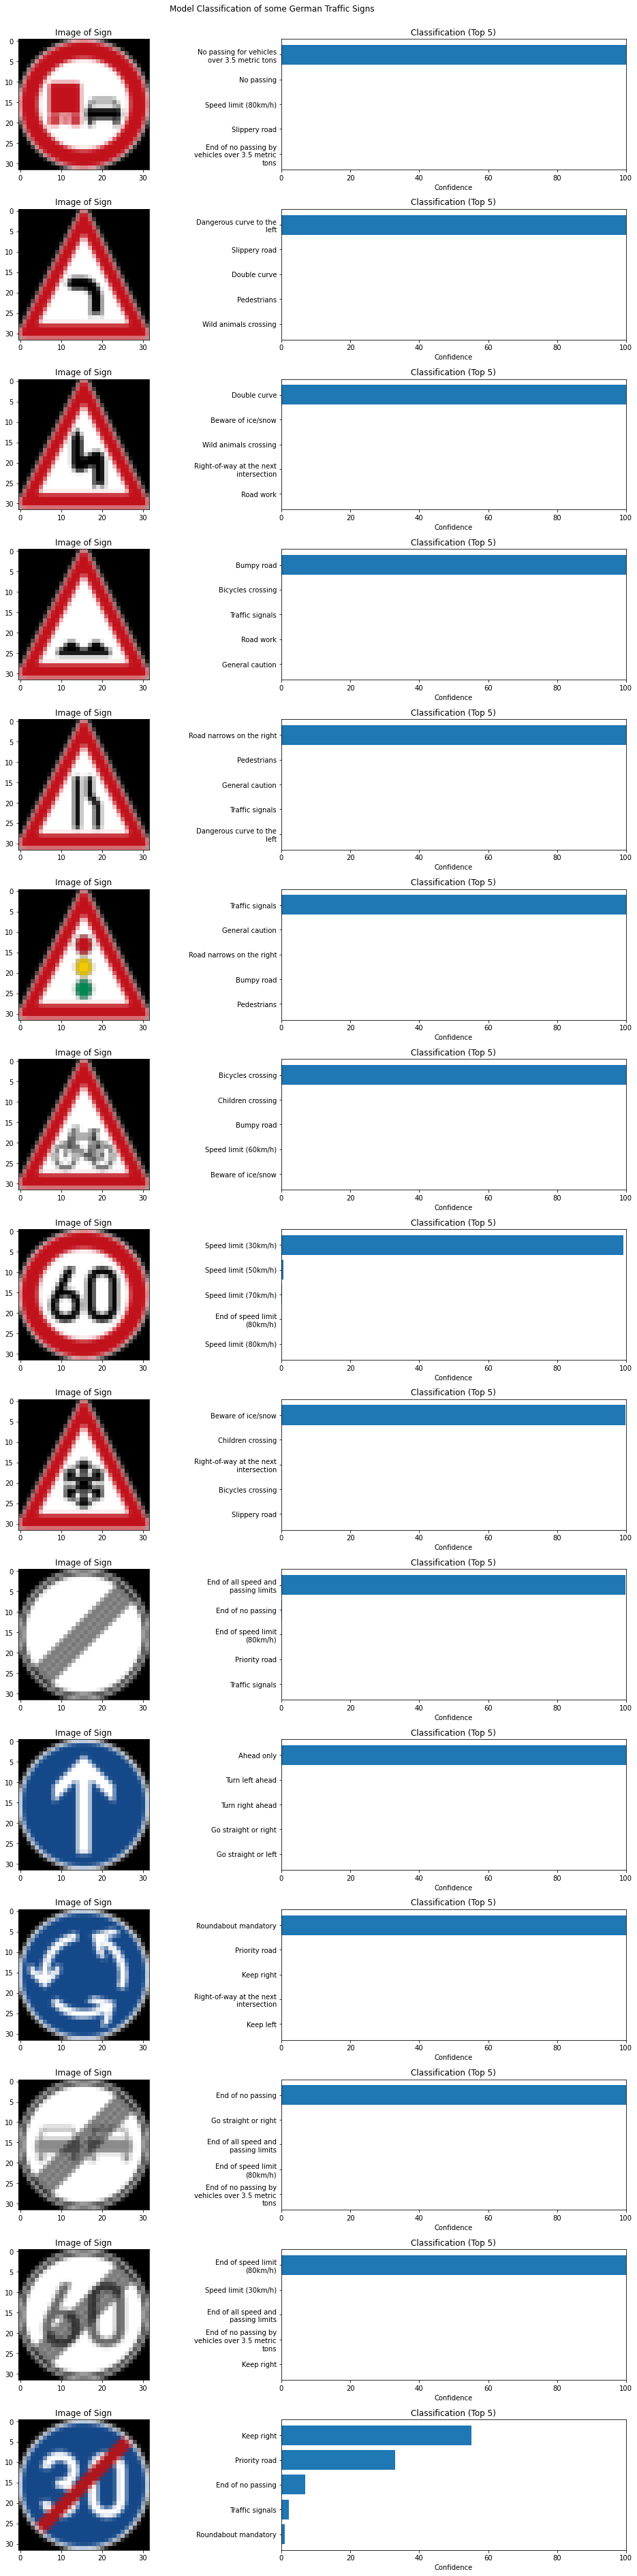

In [75]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

wiki_traffic_signs.restoreOrgImages()
wiki_traffic_signs.processImages(image_processors)
predictions = m.predict(wiki_traffic_signs.X, top=5)

vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)

In [76]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
m.test(wiki_traffic_signs.data())

Classifier-5800 | notLeNet restored.
Classifier-5800 | Test accuracy: 0.800.


Classifier-5800 | notLeNet restored.


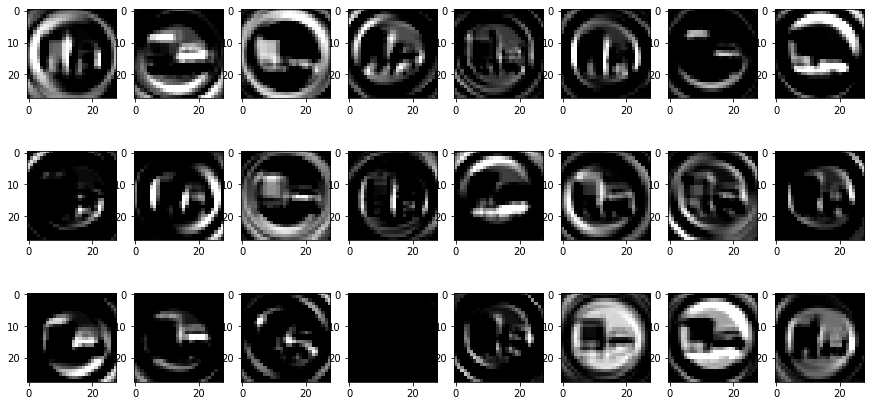

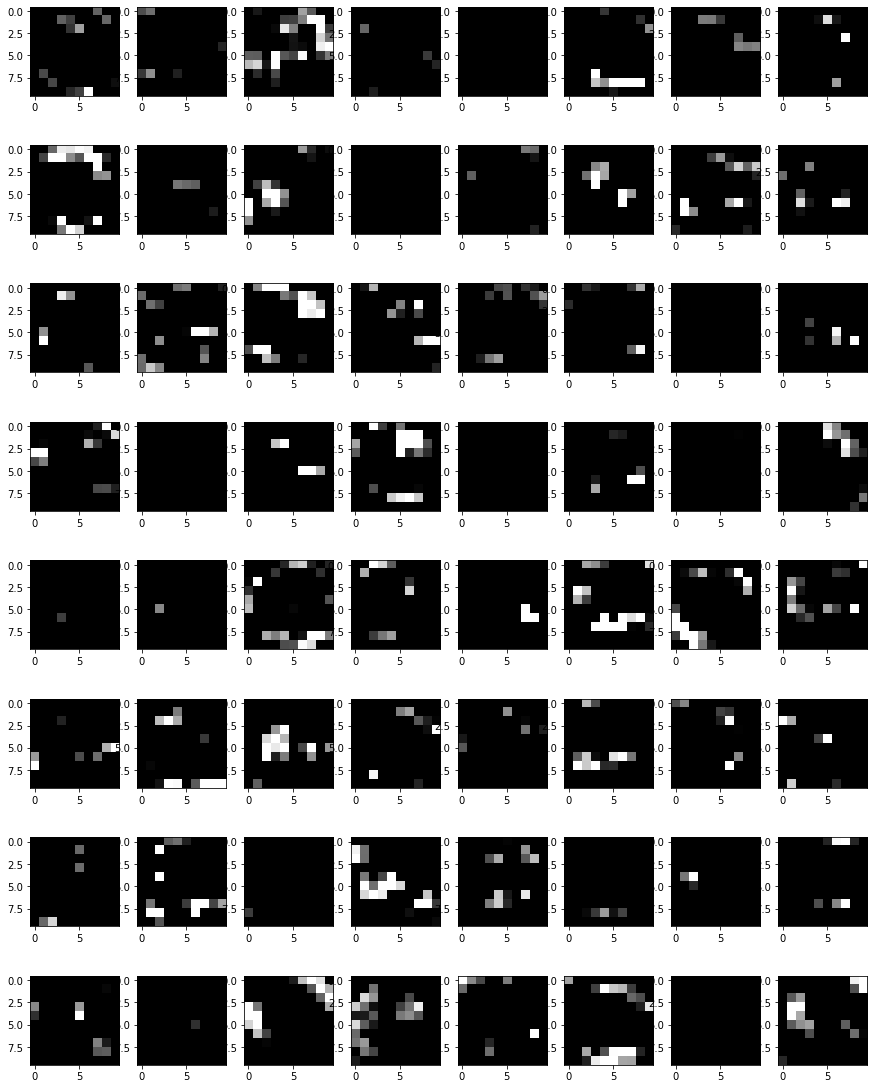

In [78]:
filename = 'traffic_signs/wikipedia/10,No passing for vehicles over 3.5 metric tons.png'
pil = Image.open(filename).convert('RGB')
pil32x32 = pil.resize((32, 32), Image.BILINEAR)
img = np.array(pil32x32)
with tf.Session() as sess:
    m.restore()
    m.featureMap(img, 0)
    m.featureMap(img, 1)


In [ ]:
filename = 'traffic_signs/wikipedia/120px-Zeichen_101-51_-_Schnee-_oder_Eisglätte,_StVO_2017.png'
pil = Image.open(filename).convert('RGB')
pil32x32 = pil.resize((32, 32), Image.BILINEAR)
img = np.array(pil32x32)
with tf.Session() as sess:
    m.restore()
    m.featureMap(img, 0)
    m.featureMap(img, 1)


In [ ]:
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
from sklearn.utils import shuffle

EPOCHS = 500
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    hi_val = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if (validation_accuracy >= 0.93):
            if validation_accuracy > hi_val:
                hi_val = validation_accuracy
                print ("New high! Saving model...")
                saver.save(sess, './lenet')
                print("Model saved")
                if hi_val >= 0.98:
                    break
    print("Highest accuracy = {:.3f}".format(hi_val))

In [ ]:
import os
os.sys.path